# Lesson 2 : LangGraph Components

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [113]:
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='classify the query into sports or not related')

class SportsTopicParser(BaseModel):
    Country: str = Field(description='Country involved in the sports query')
    Game: str = Field(description='Game or sport mentioned in the query')


class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        
        # Define nodes
        graph.add_node("llm-start", self.function_1)
        graph.add_node("sports-details", self.function_2)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        
        # Conditional routing for topics
        graph.add_conditional_edges(
            "llm-start",
            self.router,
            {True: "sports-details", False: "llm"}
        )
        
        # Conditional routing for tool invocation
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        
        # Sequential edge: If a tool is called, return to llm after action
        graph.add_edge("sports-details", END)
        graph.add_edge("action", "llm")
        
        
        # Set the entry point and compile the graph
        graph.set_entry_point("llm-start")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        self.model1=model
    
    def function_1(self, state):
        
        messages = state['messages']
        question = messages[-1]
        print(question)
        
        # Topic selection template
        template = """Your task is to provide only the topic based on the user query. 
                      Only output the topic among: [Sports, Not Related]. 
                      Don't include reasoning. Following is the user query: {question}"""
        
        
        prompt = PromptTemplate(
            template=template,
            input_variables=["question"]
        )
        
        chain = prompt | self.model1
        response_data = chain.invoke({"question": question})
        response_content = response_data.content
        print(response_content)
        response_dict = {"Topic": response_content}
        response = TopicSelectionParser(**response_dict) 
        #response = parse_topic_selection(response_data)  # Parse using TopicSelectionParser
        print("Detected Topic:", response.Topic)
        
        return {"messages": [response.Topic]}
    
    def function_2(self, state):
        messages = state['messages']
        question = messages[0]
        print(question)
        
        # Sports details extraction template
        sports_template = """Extract the country and the specific game mentioned in the user query. 
                             Provide only the country and game names. Here is the user query: {question}"""
        
        sports_prompt = PromptTemplate(
            template=sports_template,
            input_variables=["question"]
        )
        
        sports_chain = sports_prompt | self.model1
        sports_response_data = sports_chain.invoke({"question": question})
        response_content = sports_response_data.content
        
        response_dict = {}
        for line in response_content.strip().split('\n'):
            key, value = line.split(":", 1)
            response_dict[key.strip()] = value.strip()
        response = SportsTopicParser(**response_dict) 
        #sports_response = parse_sports_details(sports_response_data)  # Parse using SportsTopicParser
        
        print("Extracted Country:", response.Country)
        print("Extracted Game:", response.Game)
        
        return {"messages": [response.Country, response.Game]}
    
    def router(self, state):
        messages = state["messages"]
        print(messages)
        last_message = messages[-1]
        if 'Sports' in last_message:
            return True
        else:
             return False
    
    def exists_action(self, state):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0
    
    def call_openai(self, state):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def take_action(self, state):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling tool: {t}")
            if t['name'] not in self.tools:
                result = "Invalid tool name, please retry."
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Returning to model...")
        return {'messages': results}


In [83]:
def function_1(state):
        
        messages = state[0]
        question = messages
        print(question)
        
        # Topic selection template
        template = """Your task is to provide only the topic based on the user query. 
                      Only output the topic among: [Sports, Not Related]. 
                      Don't include reasoning. Following is the user query: {question}"""
        
        prompt = PromptTemplate(
            template=template,
            input_variables=["question"]
        )
        model = ChatOpenAI(model="gpt-3.5-turbo")
        chain = prompt | model
        response_data = chain.invoke({"question": question})
        response_content = response_data.content
        response_dict = {"Topic": response_content}
        response = TopicSelectionParser(**response_dict) 
        #response = parse_topic_selection(response_data)  # Parse using TopicSelectionParser
        print("Detected Topic:", response.Topic)
        
        return {"messages": [response.Topic]}

k=function_1(["Argentina has won football game"])
k

Argentina has won football game
Sports
Detected Topic: Sports


{'messages': ['Sports']}

In [112]:
def function_2(state):
        messages = state[0]
        question = messages
        print(question)
        
        # Sports details extraction template
        sports_template = """Extract the country and the specific game mentioned in the user query. 
                             Provide only the country and game names. Here is the user query: {question}"""
        
        sports_prompt = PromptTemplate(
            template=sports_template,
            input_variables=["question"]
        )
        model = ChatOpenAI(model="gpt-3.5-turbo")
        sports_chain = sports_prompt |model
        sports_response_data = sports_chain.invoke({"question": question})
        response_content = sports_response_data.content
        
        response_dict = {}
        for line in response_content.strip().split('\n'):
            key, value = line.split(":", 1)
            response_dict[key.strip()] = value.strip()
        response = SportsTopicParser(**response_dict) 
        print("Extracted Country:", response.Country)
        print("Extracted Game:", response.Game)
        
        return {"messages": [response.Country, response.Game]}

k=function_2(["Argentina has won football game"])
k

Argentina has won football game
Extracted Country: Argentina
Extracted Game: Football


{'messages': ['Argentina', 'Football']}

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [84]:
messages

[HumanMessage(content='Argentina has won football game')]

In [114]:
prompt = """You are a smart research assistant.  \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. 
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

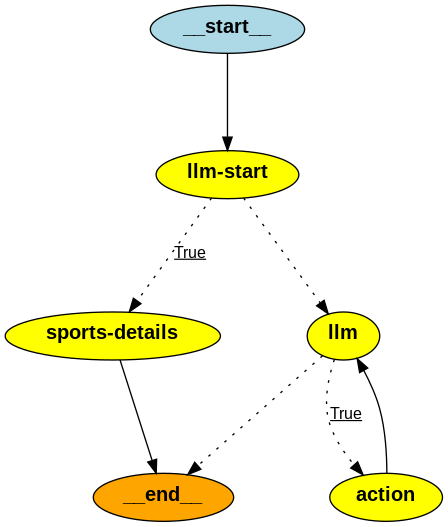

In [27]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [123]:
messages = [HumanMessage(content="Argentina has won football game")]
result = abot.graph.invoke({"messages": messages})

content='Argentina has won football game'
Sports
Detected Topic: Sports
[HumanMessage(content='Argentina has won football game'), 'Sports']
content='Argentina has won football game'
Extracted Country: Argentina
Extracted Game: football


In [124]:
result

{'messages': [HumanMessage(content='Argentina has won football game'),
  'Sports',
  'Argentina',
  'football']}

In [118]:
result['messages'][-1]

'Football'

In [125]:
result['messages'][-1].content

AttributeError: 'str' object has no attribute 'content'

In [128]:
messages = [HumanMessage(content="can you tell about EY company")]
result = abot.graph.invoke({"messages": messages})

content='can you tell about EY company'
Not Related
Detected Topic: Not Related
[HumanMessage(content='can you tell about EY company'), 'Not Related']
Calling tool: {'name': 'tavily_search_results_json', 'args': {'query': 'EY company'}, 'id': 'call_x4rl77KMgKhiH3EELASTnsUO'}
Returning to model...


In [129]:
result['messages'][-1].content

"EY, formerly known as Ernst & Young, is a global professional services firm that offers audit, tax, consulting, and strategy services. It is one of the Big Four accounting firms and operates in over 150 countries. EY was formed in 1989 through a merger between Ernst & Whinney and Arthur Young, becoming the world's largest accounting firm at the time. EY has a long history dating back over 100 years and has undergone various expansions and re-branding efforts over the years.\n\nFor more information, you can visit their official website [here](https://www.ey.com/en_us)."

In [130]:
result['messages']

[HumanMessage(content='can you tell about EY company'),
 'Not Related',
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_x4rl77KMgKhiH3EELASTnsUO', 'function': {'arguments': '{"query":"EY company"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 130, 'total_tokens': 150, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f8948048-aeeb-46c5-acfb-36250f0d4bee-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'EY company'}, 'id': 'call_x4rl77KMgKhiH3EELASTnsUO'}]),
 ToolMessage(content='[{\'url\': \'https://www.ey.com/en_us\', \'content\': \'EY is a global professional services firm that

In [127]:
result['messages']

[HumanMessage(content='Argentina has won football game'),
 'Sports',
 'Argentina',
 'football']

In [ ]:
print(result['messages'][-1].content)